In [43]:
#!pip install ucimlrepo

In [44]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import statistics
import re
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from ucimlrepo import fetch_ucirepo
from sklearn.utils import class_weight
from functools import partial
import warnings

warnings.filterwarnings('ignore')


In [45]:
sys.path.append(os.path.abspath("/home/bk_anupam/code/ML/ML_UTILS/"))

In [46]:
import train_tabular_utils as tt
import cv_split_utils
import enums
import data_utils

In [47]:
class Config:
    RUN_MODE = "LOCAL"
    RANDOM_SEED = 42
    NUM_FOLDS = 5
    TARGET_COL_NAME = "Target"        
    SCALER = enums.Scaler.StandardScaler
    METRIC = enums.Metrics.ACCURACY
    # These values are more dynamic   
    MODEL_TYPE = enums.ModelName.CatBoost
    NUM_TUNING_TRIALS = 2
    TUNE_ON_SINGLE_FOLD = True
    TRAIN_SINGLE_FOLD = False    
    PERSIST_MODEL = False
    USE_OPENFE_FEATURES = True
    CREATE_MANUAL_FEATURES = False
    USE_ORIGINAL_DATA = True

COLS_TO_LEAVE = ["id", "Target", "kfold"]
CPU_COUNT = os.cpu_count()

DATA_READPATH = "./data/"
DATA_WRITEPATH = "./output/"
SUBMISSION_FILEPATH = DATA_READPATH
if Config.RUN_MODE == "KAGGLE":    
    DATA_READPATH = "/kaggle/input/playground-series-s4e6/"
    if Config.USE_OPENFE_FEATURES:
        DATA_READPATH = "/kaggle/input/ps4e6-openfe/"
    SUBMISSION_FILEPATH = "/kaggle/input/playground-series-s4e6/"
    DATA_WRITEPATH = "/kaggle/working/"

In [48]:
# fetch original dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
df_train_orig = predict_students_dropout_and_academic_success.data.features 
df_train_orig[Config.TARGET_COL_NAME] = predict_students_dropout_and_academic_success.data.targets[Config.TARGET_COL_NAME]
# rename column 'Marital Status' to 'Marital status'
df_train_orig = df_train_orig.rename(columns={'Marital Status': 'Marital status'})

In [49]:
# no missing values in original data
na_orig = df_train_orig.isna().sum()
na_orig.loc[na_orig > 0]

Series([], dtype: int64)

In [50]:
if Config.USE_OPENFE_FEATURES and not Config.USE_ORIGINAL_DATA:
    print("using generated openfe features only on train data")
    df_train = pd.read_csv(DATA_READPATH + "train_openfe.csv")    
    df_test = pd.read_csv(DATA_READPATH + "test_openfe.csv")
elif Config.USE_OPENFE_FEATURES and Config.USE_ORIGINAL_DATA:
    print("using generated openfe features on both train and original data")
    df_train = pd.read_csv(DATA_READPATH + "train_orig_openfe.csv")    
    df_test = pd.read_csv(DATA_READPATH + "test_orig_openfe.csv")
else:    
    df_train = pd.read_csv(DATA_READPATH + "train.csv")
    df_train = df_train.drop("id", axis=1)    
    df_test = pd.read_csv(DATA_READPATH + "test.csv")
    df_test = df_test.drop("id", axis=1)
    if Config.USE_ORIGINAL_DATA:
        # add df_train_orig rows to df_train
        df_train = pd.concat([df_train, df_train_orig], axis=0, ignore_index=True)

using generated openfe features on both train and original data


In [51]:
# Label encoding of target values
le = LabelEncoder()
le.fit(df_train[Config.TARGET_COL_NAME])
df_train[Config.TARGET_COL_NAME] = le.transform(df_train[Config.TARGET_COL_NAME])
list(le.classes_)

['Dropout', 'Enrolled', 'Graduate']

In [52]:
# Dropout = 0.33, Enrolled = 0.2, Graduate = 0.47
# Increase the weight of the minority class for model to focus more on the minority class
# calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(df_train.Target), y=df_train.Target)
print(class_weights)

[1.00986887 1.71480022 0.7009604 ]


In [54]:
model_static_params = {
    enums.ModelName.XGBoost: {
        "objective": "multi:softmax",
        "eval_metric": "rmse",
        "seed": Config.RANDOM_SEED,
        "verbosity": 0,
        "num_class": 3
    },
    enums.ModelName.LGBM: {
        "objective": "root_mean_squared_error",
        "metric": 'rmse',
        "verbosity": -1,    # <0: fatal, =0: error (warn), =1: info, >1: debug
        "boosting_type": "gbdt"
    },
    enums.ModelName.CatBoost: {
        "objective": "MultiClass",
        "verbose": 0,
        "random_seed": Config.RANDOM_SEED,
        "eval_metric": "Accuracy",
        'grow_policy':  'Lossguide',
        #'bootstrap_type': 'Poisson',
        #'class_weights': class_weights,
        'task_type': 'CPU'
    },
    enums.ModelName.RandomForest: {
        "random_state": Config.RANDOM_SEED,
        "n_jobs": -1
    }
}

In [55]:
# For RandomForest
# tuned_model_params = {'n_estimators': 703, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 4, 
#                 'max_features': 'log2', 'random_state': Config.RANDOM_SEED}

# For CatBoost
# tuned_model_params = {'learning_rate': 0.45126024670762294, 'n_estimators': 3700, 'max_depth': 7, 'min_data_in_leaf': 73, 'colsample_bylevel': 0.8908705634626486, 'num_leaves': 120, 'reg_lambda': 98.46961225632553, 'random_strength': 0.016359736302592447, 'early_stopping_rounds': 210, 'max_bin': 253}

tuned_model_params = None

In [56]:
def process_col_name(cols_list):
    processed_cols_list = []
    for item in cols_list:
        # Remove round brackets but keep the text inside them
        item_no_brackets = re.sub(r'[\(\)]', '', item)
        # Remove single quotes
        item_no_quotes = item_no_brackets.replace("'", "")
        # Replace spaces with underscores
        item_processed = item_no_quotes.replace(' ', '_')
        # Append to the processed list
        processed_cols_list.append(item_processed)
    return processed_cols_list

In [57]:
train_cols_list = df_train.columns.to_list()
test_cols_list = df_test.columns.to_list()
train_processed_cols_list = process_col_name(train_cols_list)
test_processed_cols_list = process_col_name(test_cols_list)
df_train.columns = train_processed_cols_list
df_test.columns = test_processed_cols_list

In [58]:
# feature engineering
def create_features(df):
    # (Tuition_fees_up_to_date*Curricular_units_2nd_sem_approved)
    df["f_1"] = df["Tuition_fees_up_to_date"] * df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_1st_sem_approved+Curricular_units_2nd_sem_approved)
    df["f_2"] = df["Curricular_units_1st_sem_approved"] + df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_2nd_sem_grade*Curricular_units_2nd_sem_approved)
    df["f_3"] = df["Curricular_units_2nd_sem_grade"] * df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_2nd_sem_grade+Curricular_units_2nd_sem_approved)
    df["f_4"] = df["Curricular_units_2nd_sem_grade"] + df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_2nd_sem_grade+Scholarship_holder)
    df["f_5"] = df["Curricular_units_2nd_sem_grade"] + df["Scholarship_holder"]
    # (Curricular_units_1st_sem_grade+Scholarship_holder)
    df["f_6"] = df["Curricular_units_1st_sem_grade"] + df["Scholarship_holder"]
    # (Curricular_units_2nd_sem_enrolled-Curricular_units_2nd_sem_approved)
    df["f_7"] = df["Curricular_units_2nd_sem_enrolled"] - df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_1st_sem_enrolled-Curricular_units_2nd_sem_approved)
    df["f_8"] = df["Curricular_units_1st_sem_enrolled"] - df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_2nd_sem_grade-Curricular_units_1st_sem_evaluations)
    df["f_9"] = df["Curricular_units_2nd_sem_grade"] - df["Curricular_units_1st_sem_evaluations"]
    # (Curricular_units_1st_sem_grade/Age_at_enrollment)
    df["f_10"] = df["Curricular_units_1st_sem_grade"] / df["Age_at_enrollment"]
    # (Curricular_units_1st_sem_evaluations-Curricular_units_2nd_sem_approved)
    df["f_11"] = df["Curricular_units_1st_sem_evaluations"] - df["Curricular_units_2nd_sem_approved"]
    # GroupByThenRank(Curricular_units_2nd_sem_approved,Curricular_units_1st_sem_enrolled)    
    df["f_12"] = df.groupby('Curricular_units_1st_sem_enrolled')['Curricular_units_2nd_sem_approved'].rank(method="dense", ascending=False)
    # GroupByThenRank(Curricular_units_2nd_sem_approved,Mothers_occupation)
    df["f_13"] = df.groupby('Mothers_occupation')['Curricular_units_2nd_sem_approved'].rank(method="dense", ascending=False)
    # GroupByThenRank(Scholarship_holder,Age_at_enrollment)
    df["f_14"] = df.groupby('Age_at_enrollment')['Scholarship_holder'].rank(method="dense", ascending=False)
    # GroupByThenRank(Scholarship_holder,Curricular_units_2nd_sem_approved)
    df["f_15"] = df.groupby('Curricular_units_2nd_sem_approved')['Scholarship_holder'].rank(method="dense", ascending=False)
    # CombineThenFreq(Course,Curricular_units_1st_sem_approved)
    df["f_16"] = df.groupby('Course')['Curricular_units_1st_sem_approved'].transform('count')
    return df

In [59]:
if Config.CREATE_MANUAL_FEATURES:
    df_train = create_features(df_train)
    df_test = create_features(df_test)

In [60]:
na_val = df_train.isna().sum()
null_features = na_val.loc[na_val > 0].index.values.tolist()
null_features

['autoFE_f_1',
 'autoFE_f_2',
 'autoFE_f_3',
 'autoFE_f_5',
 'autoFE_f_6',
 'autoFE_f_7',
 'autoFE_f_10',
 'autoFE_f_13',
 'autoFE_f_15',
 'autoFE_f_16',
 'autoFE_f_17',
 'autoFE_f_18',
 'autoFE_f_19',
 'autoFE_f_23',
 'autoFE_f_31',
 'autoFE_f_37',
 'autoFE_f_42',
 'autoFE_f_47']

In [61]:
cat_features = ['Marital_status', 'Application_mode', 'Course', 'Daytime/evening_attendance', 'Previous_qualification',
    'Nacionality', 'Mothers_qualification', 'Fathers_qualification', 'Mothers_occupation', 'Fathers_occupation', 'Displaced',
    'Educational_special_needs', 'Debtor', 'Tuition_fees_up_to_date','Gender', 'Scholarship_holder', 'International']

In [62]:
cont_features = [x for x in df_train.dtypes[df_train.dtypes == "float"].index.values if x not in null_features]
int_features = [x for x in df_train.dtypes[df_train.dtypes == "int"].index.values if x not in COLS_TO_LEAVE+null_features]
feature_cols = df_test.columns.to_list()
feature_cols_after_fe = [x for x in df_train.columns if x not in COLS_TO_LEAVE+null_features]

In [63]:
# for categorical features find the categories to be used for one hot encoding
int_feature_categories = []
for int_feature in int_features:
    int_feature_categories.append(sorted(df_train[int_feature].unique()))

In [64]:
print(f"len(feature_cols_after_fe)={len(feature_cols_after_fe)}")
print(feature_cols_after_fe)

len(feature_cols_after_fe)=68
['Marital_status', 'Application_mode', 'Application_order', 'Course', 'Daytime/evening_attendance', 'Previous_qualification', 'Previous_qualification_grade', 'Nacionality', 'Mothers_qualification', 'Fathers_qualification', 'Mothers_occupation', 'Fathers_occupation', 'Admission_grade', 'Displaced', 'Educational_special_needs', 'Debtor', 'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder', 'Age_at_enrollment', 'International', 'Curricular_units_1st_sem_credited', 'Curricular_units_1st_sem_enrolled', 'Curricular_units_1st_sem_evaluations', 'Curricular_units_1st_sem_approved', 'Curricular_units_1st_sem_grade', 'Curricular_units_1st_sem_without_evaluations', 'Curricular_units_2nd_sem_credited', 'Curricular_units_2nd_sem_enrolled', 'Curricular_units_2nd_sem_evaluations', 'Curricular_units_2nd_sem_approved', 'Curricular_units_2nd_sem_grade', 'Curricular_units_2nd_sem_without_evaluations', 'Unemployment_rate', 'Inflation_rate', 'GDP', 'autoFE_f_0', 'autoFE_f

In [65]:
# preprocessing
preprocessor = None
scaler = StandardScaler()
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore", categories=int_feature_categories)
if Config.MODEL_TYPE == enums.ModelName.LogisticRegression:
    preprocessor = ColumnTransformer(
        transformers=[                
            ("scaler", scaler, feature_cols_after_fe),
            ("onehot", onehot_encoder, int_features),                
        ], remainder="passthrough"
    )
else:
    preprocessor = ColumnTransformer(
        transformers=[                
            ("scaler", scaler, cont_features)     
        ], remainder="passthrough"
    )

In [ ]:
def get_xgb_tuning_params(trial):
    params_dynamic = {            
            'n_estimators': trial.suggest_int('n_estimators', 1000, 5000, step=100),
            'learning_rate': trial.suggest_float('learning_rate', 1e-2, 1.0, log=True),
            'max_depth': trial.suggest_int('max_depth', 4, 32),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
            'reg_lambda': trial.suggest_float('reg_lambda', 1, 200),
            'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 100, 500, step=20)
        }
    return {**model_static_params[enums.ModelName.XGBoost], **params_dynamic}

In [66]:
def get_catboost_tuning_params(trial):
    params_dynamic = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 5000, step=50),
        'max_depth': trial.suggest_int('max_depth', 4, 16),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
        #'subsample': trial.suggest_float('subsample', 0.5, 1),
        # comment colsample_bylevel for GPU training
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1),
        'num_leaves': trial.suggest_int('num_leaves', 4, 256, step=4),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 100),
        'random_strength': trial.suggest_loguniform('random_strength', 0.01, 10),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 50, 500, step=20),
        'max_bin': trial.suggest_int('max_bin', 32, 255)
    }
    return {**model_static_params[enums.ModelName.CatBoost], **params_dynamic}

In [67]:
def get_model_tuning_params(trial, model_name):    
    if model_name == enums.ModelName.RandomForest:
        return {        
            "n_estimators": trial.suggest_int("n_estimators", 200, 3000, step=100),
            "max_depth": trial.suggest_int("max_depth", 10, 30),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 16),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 16),
            "max_features": trial.suggest_categorical("max_features", ["log2", "sqrt", None])
        }
    if model_name == enums.ModelName.CatBoost:
        return get_catboost_tuning_params(trial)
    if model_name == enums.ModelName.XGBoost:
        return get_xgb_tuning_params(trial)    

In [68]:
def hyperparams_tuning_objective(trial, model_name, preprocessor, df,  
                                 feature_cols, metric, target_col_name, single_fold=False, num_folds=5):               
    model_params = get_model_tuning_params(trial, model_name)    
    fold_metrics_model, _, _ = tt.train_and_validate(
                                        model_name=model_name,
                                        model_params=model_params,
                                        preprocessor=preprocessor,
                                        df=df,
                                        feature_cols=feature_cols,
                                        target_col_name=target_col_name,
                                        metric=metric,
                                        single_fold=single_fold,
                                        num_folds=num_folds,
                                        suppress_print=True
                                    )
    fold_metrics = [x[0] for x in fold_metrics_model]
    mean_metric = statistics.mean(fold_metrics)                
    return mean_metric

In [69]:
def tune_model_params(study_name, study_direction, num_trials, model_name, 
                      preprocessor, df,  feature_cols, metric, target_col_name, 
                      single_fold=False, num_folds=5):
    model_params_tuning_obj_partial = partial(
        hyperparams_tuning_objective,
        model_name=model_name,        
        preprocessor=preprocessor,        
        df=df,
        feature_cols=feature_cols,
        metric=metric,
        target_col_name=target_col_name,
        single_fold=single_fold,
        num_folds=num_folds
    )
    study = optuna.create_study(direction=study_direction, study_name=study_name)
    study.optimize(model_params_tuning_obj_partial, n_trials=num_trials)
    best_trial = study.best_trial
    print(f"Best trial: number = {best_trial.number}, value = {best_trial.value}, params = {best_trial.params}")
    return best_trial.params

In [70]:
df_train = cv_split_utils.strat_kfold_dataframe(df_train, 
                                                target_col_name=Config.TARGET_COL_NAME, 
                                                random_state=Config.RANDOM_SEED, 
                                                num_folds=Config.NUM_FOLDS)

In [71]:
if tuned_model_params is None:
    #df = df_train.sample(frac=0.1, random_state=Config.RANDOM_SEED)
    tuned_model_params = tune_model_params(
                            study_name=Config.MODEL_TYPE + "_ModelTuning", 
                            study_direction="maximize",
                            num_trials=Config.NUM_TUNING_TRIALS,
                            model_name=Config.MODEL_TYPE,
                            preprocessor=preprocessor,
                            df=df_train,
                            feature_cols=feature_cols_after_fe,
                            metric=Config.METRIC,
                            target_col_name=Config.TARGET_COL_NAME,
                            single_fold=Config.TUNE_ON_SINGLE_FOLD,
                            num_folds=Config.NUM_FOLDS
                    )

In [72]:
model_params = None
params_static = model_static_params.get(Config.MODEL_TYPE)
if params_static is not None and tuned_model_params is not None:
    model_params = {**model_static_params[Config.MODEL_TYPE], **tuned_model_params}
else:
    model_params = tuned_model_params

In [73]:
%%time
fold_metrics_model, df_oof_preds, preprocessor = tt.train_and_validate(
        model_name=Config.MODEL_TYPE,
        model_params=model_params,
        preprocessor=preprocessor,
        df=df_train,
        feature_cols=feature_cols_after_fe,
        target_col_name=Config.TARGET_COL_NAME,
        metric=Config.METRIC,
        single_fold=Config.TRAIN_SINGLE_FOLD,
        num_folds=Config.NUM_FOLDS,
        suppress_print=False
)

Fold 0 - CatBoost - ACCURACY : 0.8304404225091111
Fold 1 - CatBoost - ACCURACY : 0.8263018098709
Fold 2 - CatBoost - ACCURACY : 0.8275265628860885
Fold 3 - CatBoost - ACCURACY : 0.829194465035829
Fold 4 - CatBoost - ACCURACY : 0.8276501111934766
CatBoost metric=ACCURACY CV score = 0.8282226779669393
CatBoost Mean ACCURACY = 0.8282226742990811, std = 0.00143978499226586
CPU times: user 18min 59s, sys: 1min 17s, total: 20min 17s
Wall time: 3min 1s


In [74]:
def get_agg_confusion_matrix(fold_metrics_model, preprocessor, df_train, feature_cols, target_col_name, num_folds=5):
    cm = []
    for fold in range(Config.NUM_FOLDS):
        df_train_fold, df_val_fold = tt.get_fold_df(df_train, fold)
        train_X, train_y, val_X, val_y = tt.get_train_val_nparray(df_train_fold, df_val_fold, feature_cols, target_col_name)
        if preprocessor is not None:
            val_X = preprocessor.transform(val_X)
        val_preds = fold_metrics_model[fold][1].predict(val_X)
        cm.append(confusion_matrix(val_y, val_preds))
    # sum the individual confusion matrices
    agg_cm = np.sum(cm, axis=0)
    return agg_cm

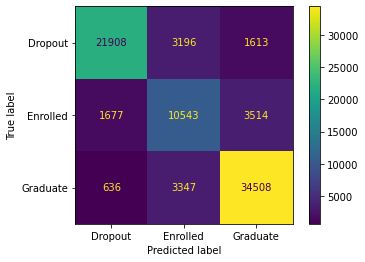

In [75]:
agg_cm = get_agg_confusion_matrix(fold_metrics_model, preprocessor, df_train, 
                                  feature_cols=feature_cols_after_fe, 
                                  target_col_name=Config.TARGET_COL_NAME, 
                                  num_folds=Config.NUM_FOLDS)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=agg_cm, display_labels=le.classes_)
disp.plot()
plt.show()

In [76]:
print(classification_report(df_oof_preds.Target.values, df_oof_preds.oof_preds.values, target_names=le.classes_))

              precision    recall  f1-score   support

     Dropout       0.90      0.82      0.86     26717
    Enrolled       0.62      0.67      0.64     15734
    Graduate       0.87      0.90      0.88     38491

    accuracy                           0.83     80942
   macro avg       0.80      0.80      0.80     80942
weighted avg       0.83      0.83      0.83     80942



In [77]:
tt.persist(
    model_name=Config.MODEL_TYPE, 
    fold_metrics_model=fold_metrics_model, 
    df_oof_preds=df_oof_preds, 
    persist_model=Config.PERSIST_MODEL, 
    output_path=DATA_WRITEPATH
)

Saved validation data predictions to df_val_preds_CatBoost.csv


In [78]:
test_preds_final = tt.get_test_preds_clf(fold_metrics_model, df_test, feature_cols_after_fe, 
                                         preprocessor=preprocessor, num_folds=Config.NUM_FOLDS)
# convert test_preds to string using labelencoder
test_preds_final = le.inverse_transform(test_preds_final)
print(f"test_preds_final shape: {test_preds_final.shape}")
df_submission = pd.read_csv(SUBMISSION_FILEPATH + 'sample_submission.csv')
df_submission[Config.TARGET_COL_NAME]= test_preds_final
df_submission.to_csv(DATA_WRITEPATH + f'submission_{Config.MODEL_TYPE}.csv',index=False)
df_submission.head()

test_X shape: (51012, 68)
combined_test_preds shape: (51012, 3)
test_preds_final shape: (51012,)


,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Graduate
4,76522,Enrolled


In [79]:
# Define a function to extract the part after '__' (vectorized for speed)
def extract_after_delimiter(text):
  return text.split("__", 1)[1] if len(text.split("__")) > 1 else text

features = preprocessor.get_feature_names_out()
# Apply the function to the feature names using lambda
features = list(map(extract_after_delimiter, features))
len(features)

68

In [80]:
def get_feature_importance(model, features):
    df_feature_imp = pd.DataFrame()
    df_feature_imp["f_name"] = features
    df_feature_imp["f_imp"] = model.feature_importances_
    df_feature_imp = df_feature_imp.sort_values(by="f_imp", ascending=False)
    return df_feature_imp

In [ ]:
if Config.MODEL_TYPE in [enums.ModelName.CatBoost, enums.ModelName.LGBM, enums.ModelName.XGB, enums.ModelName.RF]:
    df_feature_imp = get_feature_importance(fold_metrics_model[0][1], features)
    df_feature_imp.to_csv(DATA_WRITEPATH + f"{Config.MODEL_TYPE}_feature_imp_orig_openfe.csv", index=False)

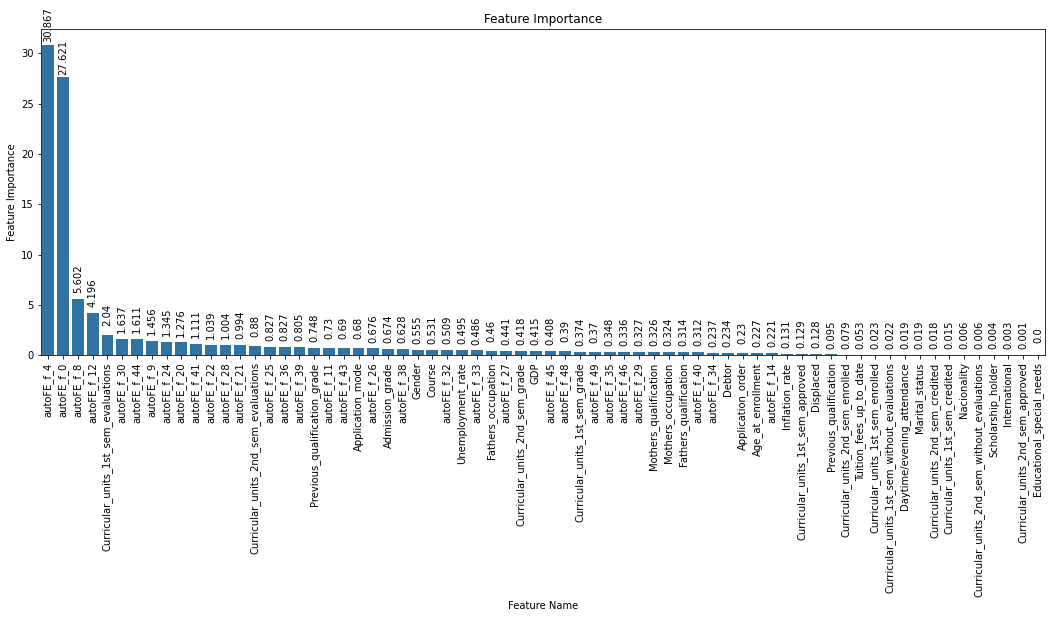

In [82]:
data_utils.plot_feature_importance(df_feature_imp, fig_size=(18, 6))

In [83]:
# from sklearn.ensemble import RandomForestClassifier

# fs_model = RandomForestClassifier(**model_params)
# sfs = SequentialFeatureSelector(model, n_features_to_select=50, scoring="accuracy")
# sfs.fit(df_train[feature_cols_after_fe], df_train[Config.TARGET_COL_NAME])

In [84]:
# # performing feature selection by removing bottom 8 features leads to an improvment in cv score for catboost
# # from 0.82996 to 0.83129. Forward feature selection algorithm might help to improve cv score further
# df_feature_imp = df_feature_imp.head(60)
# feature_cols_new = df_feature_imp.f_name.values

In [85]:
# cont_features1 = [x for x in df_train[feature_cols_new].dtypes[df_train.dtypes == "float"].index.values if x not in null_features]
# scaler1 = StandardScaler()
# preprocessor1 = ColumnTransformer(
#     transformers=[                
#         ("scaler", scaler1, cont_features1),        
#     ], remainder="passthrough"
# )

In [86]:
# fold_metrics_model1, df_oof_preds1, preprocessor1 = tt.train_and_validate(
#         model_name=Config.MODEL_TYPE,
#         model_params=model_params,
#         preprocessor=preprocessor1,
#         df=df_train,
#         feature_cols=feature_cols_new,
#         target_col_name=Config.TARGET_COL_NAME,
#         metric=Config.METRIC,
#         single_fold=Config.TRAIN_SINGLE_FOLD,
#         num_folds=Config.NUM_FOLDS,
#         suppress_print=False
# )

In [87]:
# tt.persist(
#     model_name=Config.MODEL_TYPE, 
#     fold_metrics_model=fold_metrics_model1, 
#     df_oof_preds=df_oof_preds, 
#     persist_model=Config.PERSIST_MODEL, 
#     output_path=DATA_WRITEPATH
# )

In [88]:
# test_preds_final1 = tt.get_test_preds_clf(fold_metrics_model1, df_test, feature_cols_new, 
#                                          preprocessor=preprocessor1, num_folds=Config.NUM_FOLDS)
# # convert test_preds to string using labelencoder
# test_preds_final1 = le.inverse_transform(test_preds_final1)
# print(f"test_preds_final1 shape: {test_preds_final1.shape}")
# df_submission = pd.read_csv(SUBMISSION_FILEPATH + 'sample_submission.csv')
# df_submission[Config.TARGET_COL_NAME]= test_preds_final1
# df_submission.to_csv(DATA_WRITEPATH + f'submission_{Config.MODEL_TYPE}2.csv',index=False)
# df_submission.head()